### Import libraries

In [155]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)


2.10.0


### Set seed for reproducibility

In [156]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

 # Load the training dataset

In [157]:
path = os.getcwd()
# Load the .npy file
X = np.load(path+r'\training\x_train.npy')
y = np.load(path+r'\training\y_train.npy')
print(X.shape)   #Note as sequences are already built, with window 36
print(y.shape)
print(X.dtype)
print(y.dtype)

(2429, 36, 6)
(2429,)
float64
int32


In [158]:
# Map classes STRINGS to integers
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

Plotting the classes distributions

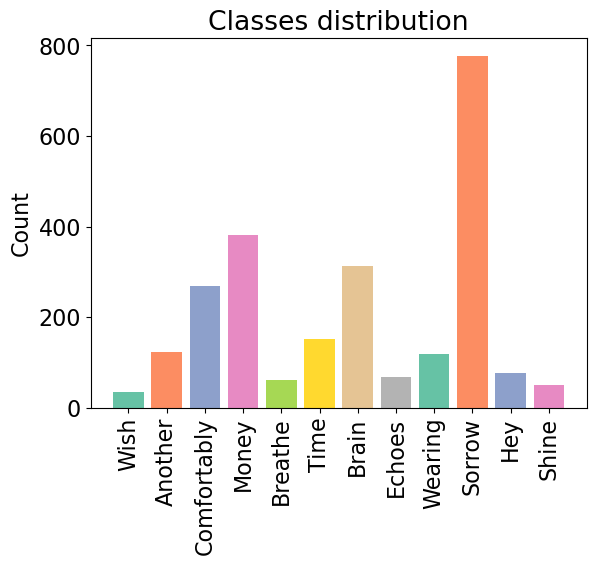

In [159]:
#vertical bar plot of the classes distribution in y
plt.title('Classes distribution')
plt.bar(label_mapping.keys(), np.bincount(y), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()


 Train-test split

In [160]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(X_train.shape)
print(X_test.shape)

(1943, 36, 6)
(486, 36, 6)


Application of Min Max Scaler to the dataset

In [161]:
features_num = X_train.shape[2]
print("features: ", features_num)

scalers = {}
for i in range(features_num):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(features_num):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

features:  6


In [162]:
'''
X_train_2d = np.reshape(X_train, (len(X_train[:, 0 , 0]), 36 * 6))
X_test_2d = np.reshape(X_test, (len(X_test[:, 0 , 0]), 36 * 6))


# Fit the scaler to the training data and apply the scaling on the training data
X_train = scaler.fit_transform(X_train_2d)
# Apply the scaling on validation data
X_test = scaler.transform(X_test_2d)
#Getting back to orginal shape
X_train = np.reshape(X_train, (1943, 36, 6))
X_test = np.reshape(X_test, (486, 36, 6))
'''

'\nX_train_2d = np.reshape(X_train, (len(X_train[:, 0 , 0]), 36 * 6))\nX_test_2d = np.reshape(X_test, (len(X_test[:, 0 , 0]), 36 * 6))\n\n\n# Fit the scaler to the training data and apply the scaling on the training data\nX_train = scaler.fit_transform(X_train_2d)\n# Apply the scaling on validation data\nX_test = scaler.transform(X_test_2d)\n#Getting back to orginal shape\nX_train = np.reshape(X_train, (1943, 36, 6))\nX_test = np.reshape(X_test, (486, 36, 6))\n'

Categorical labels for the training and test data

In [163]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(1943, 12)
(486, 12)


## Build the models

In [164]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200


#### Vanilla Long Short Term Memory (LSTM) Neural Network

In [165]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(256, return_sequences=True)(input_layer)    # return_sequences=True -> output = batch_size * timestamps * features
                                                                 # return_sequences=False -> output = batch_size * 1 (just last timestamp) * features
    lstm = tfkl.LSTM(256, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(256, return_sequences=False)(lstm)
    dropout = tfkl.Dropout(.3, seed=seed)(lstm)

    # Classifier
    dense = tfkl.Dense(256, activation='relu')(dropout)
    dense = tfkl.Dense(256, activation='relu')(dense)
    output_layer = tfkl.Dense(classes, activation='softmax')(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model1')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [166]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_27 (LSTM)              (None, 36, 256)           269312    
                                                                 
 lstm_28 (LSTM)              (None, 36, 256)           525312    
                                                                 
 lstm_29 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 256)               65792     
                                                                 
 dense_33 (Dense)            (None, 256)               65792

In [167]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
14/14 [==============================] - 9s 242ms/step - loss: 1.9839 - accuracy: 0.3495 - val_loss: 1.5662 - val_accuracy: 0.4410 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - 1s 70ms/step - loss: 1.5029 - accuracy: 0.4811 - val_loss: 1.3586 - val_accuracy: 0.5026 - lr: 0.0010
Epoch 3/200
14/14 [==============================] - 1s 69ms/step - loss: 1.2693 - accuracy: 0.5744 - val_loss: 1.1540 - val_accuracy: 0.6513 - lr: 0.0010
Epoch 4/200
14/14 [==============================] - 1s 65ms/step - loss: 1.1091 - accuracy: 0.6299 - val_loss: 1.1665 - val_accuracy: 0.6205 - lr: 0.0010
Epoch 5/200
14/14 [==============================] - 1s 68ms/step - loss: 1.0368 - accuracy: 0.6568 - val_loss: 1.1479 - val_accuracy: 0.5949 - lr: 0.0010
Epoch 6/200
14/14 [==============================] - 1s 61ms/step - loss: 0.9491 - accuracy: 0.6699 - val_loss: 1.1930 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/200
14/14 [==============================] - 1s 60ms/step - l

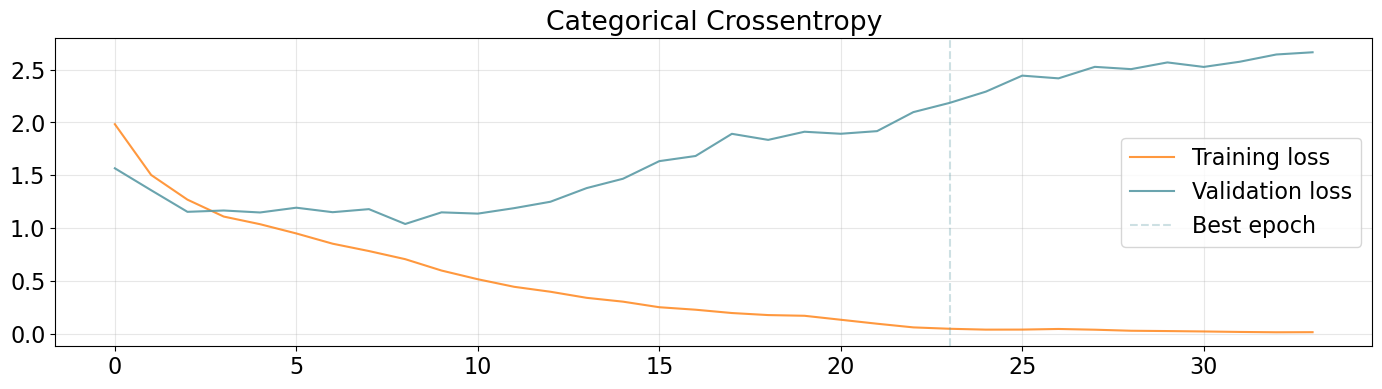

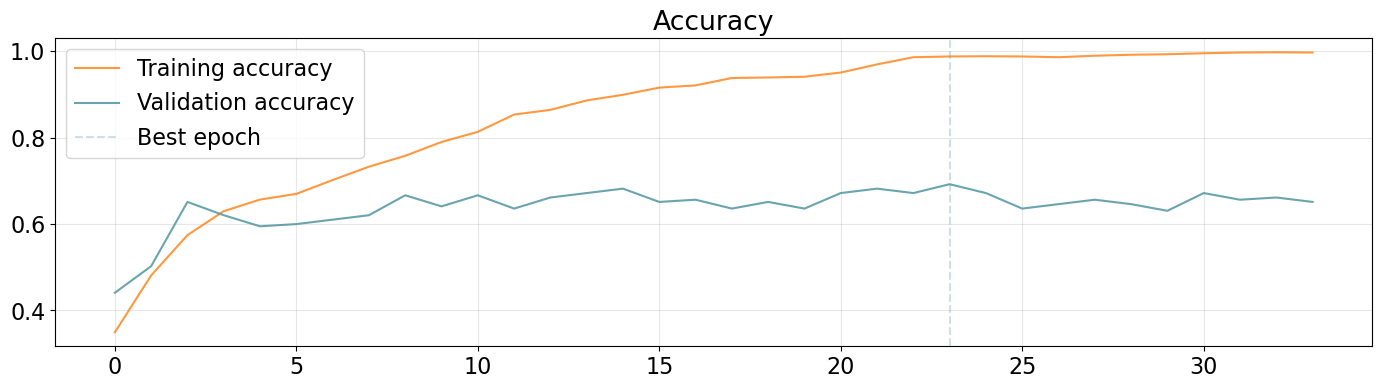

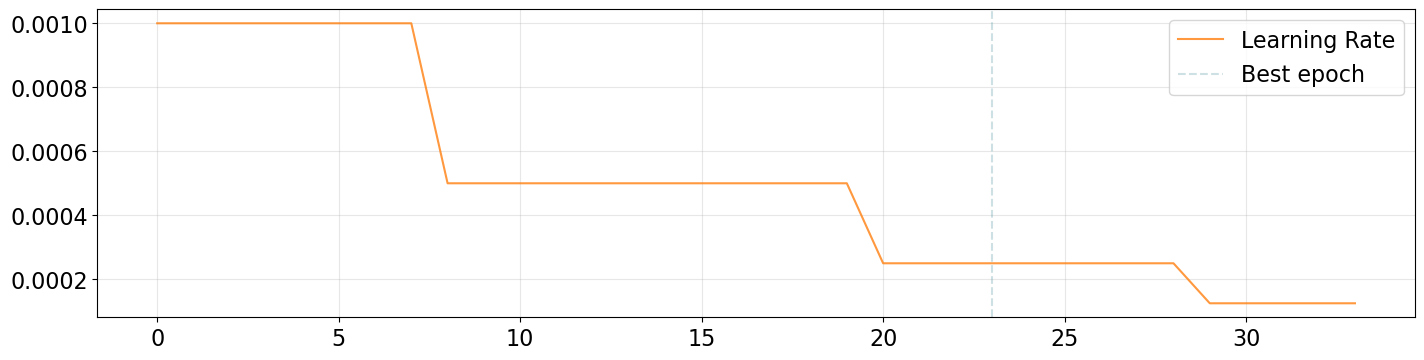

In [168]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

LSTM model evaluation

In [169]:
# Predict the test set with the LSTM
predictions = model.predict(X_test)
predictions.shape

16/16 [==============================] - 1s 12ms/step


(486, 12)

Accuracy: 0.6214
Precision: 0.5824
Recall: 0.496
F1: 0.5088


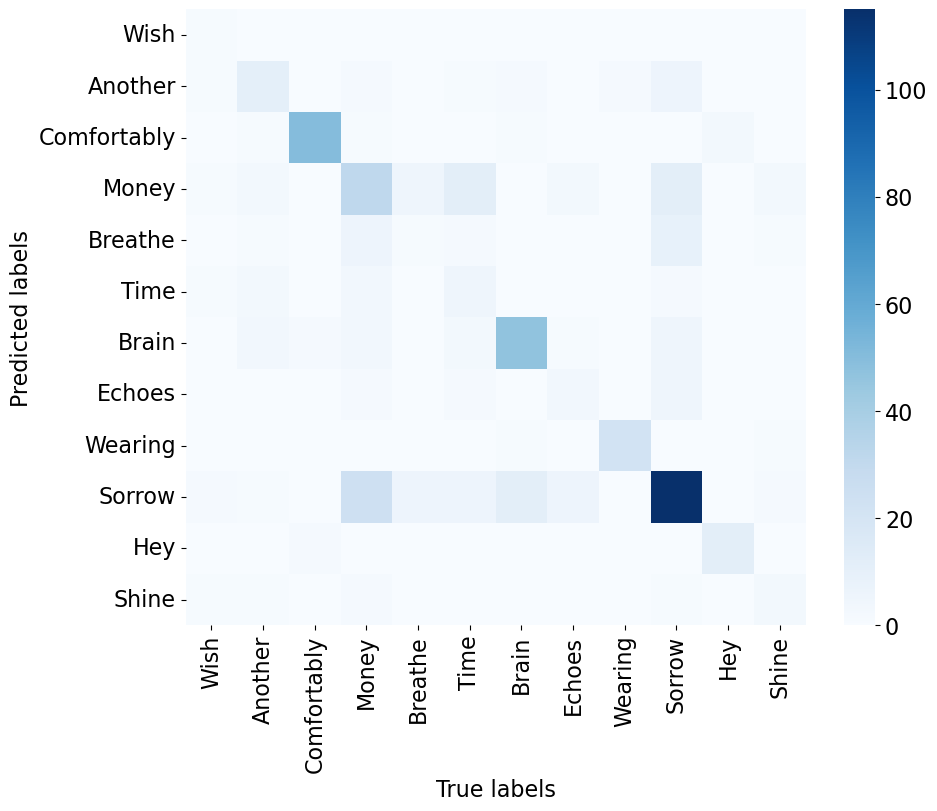

In [170]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### Bidirectional Long Short Term Memory (BiLSTM) Neural Network

In [171]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=False))(bilstm)
    dropout = tfkl.Dropout(.4, seed=seed)(bilstm)

    # Classifier
    dense = tfkl.Dense(256, activation='relu')(dropout)
    dense = tfkl.Dense(128, activation='relu')(dense)
    output_layer = tfkl.Dense(classes, activation='softmax')(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model2')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [172]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary() #note double number of parameters (this is because we have 2 lstm)

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 36, 512)          538624    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 36, 512)          1574912   
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 512)              1574912   
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                            

In [173]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
14/14 [==============================] - 18s 410ms/step - loss: 1.8319 - accuracy: 0.3970 - val_loss: 1.4335 - val_accuracy: 0.4769 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - 2s 144ms/step - loss: 1.3901 - accuracy: 0.5114 - val_loss: 1.2131 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 3/200
14/14 [==============================] - 2s 142ms/step - loss: 1.1288 - accuracy: 0.6093 - val_loss: 1.1146 - val_accuracy: 0.5897 - lr: 0.0010
Epoch 4/200
14/14 [==============================] - 2s 143ms/step - loss: 1.0030 - accuracy: 0.6608 - val_loss: 1.0808 - val_accuracy: 0.5795 - lr: 0.0010
Epoch 5/200
14/14 [==============================] - 2s 146ms/step - loss: 0.8806 - accuracy: 0.7065 - val_loss: 1.0696 - val_accuracy: 0.6615 - lr: 0.0010
Epoch 6/200
14/14 [==============================] - 2s 148ms/step - loss: 0.7677 - accuracy: 0.7397 - val_loss: 1.0842 - val_accuracy: 0.6256 - lr: 0.0010
Epoch 7/200
14/14 [==============================] - 2s 149ms/s

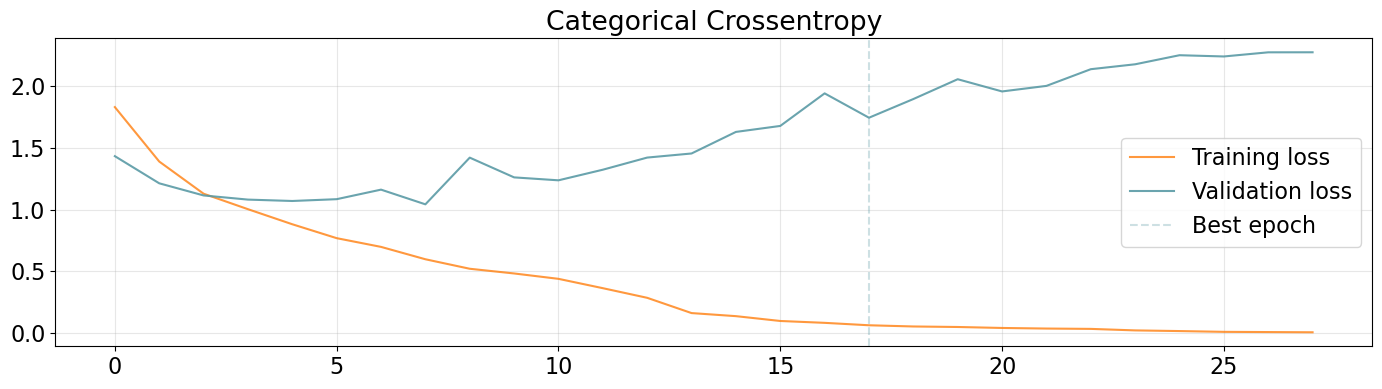

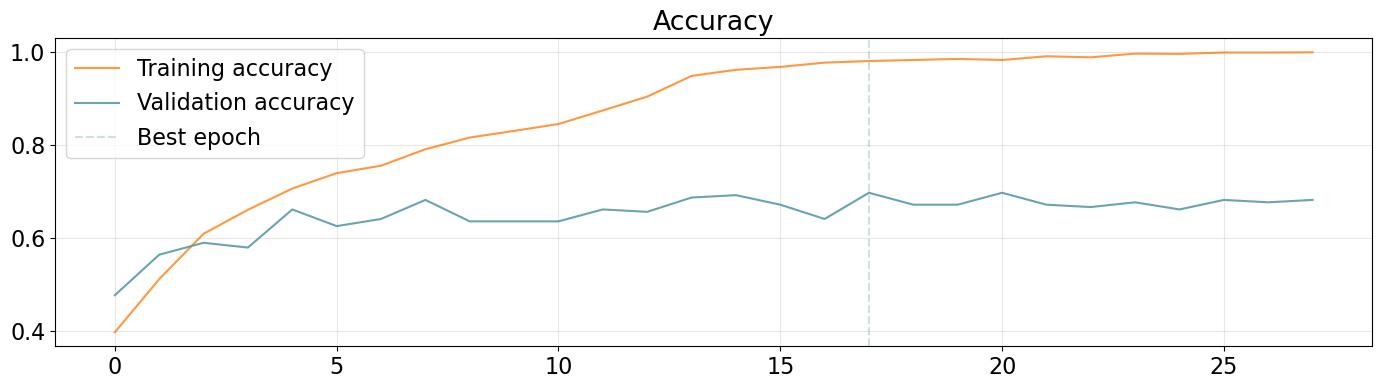

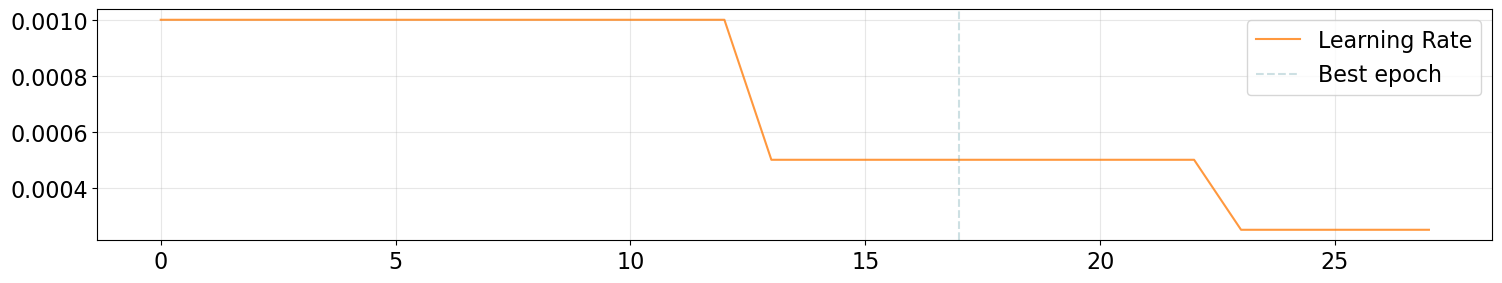

In [174]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Bidirectional LSTM model evaluation

In [175]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

16/16 [==============================] - 3s 29ms/step


(486, 12)

Accuracy: 0.6626
Precision: 0.6073
Recall: 0.5374
F1: 0.5581


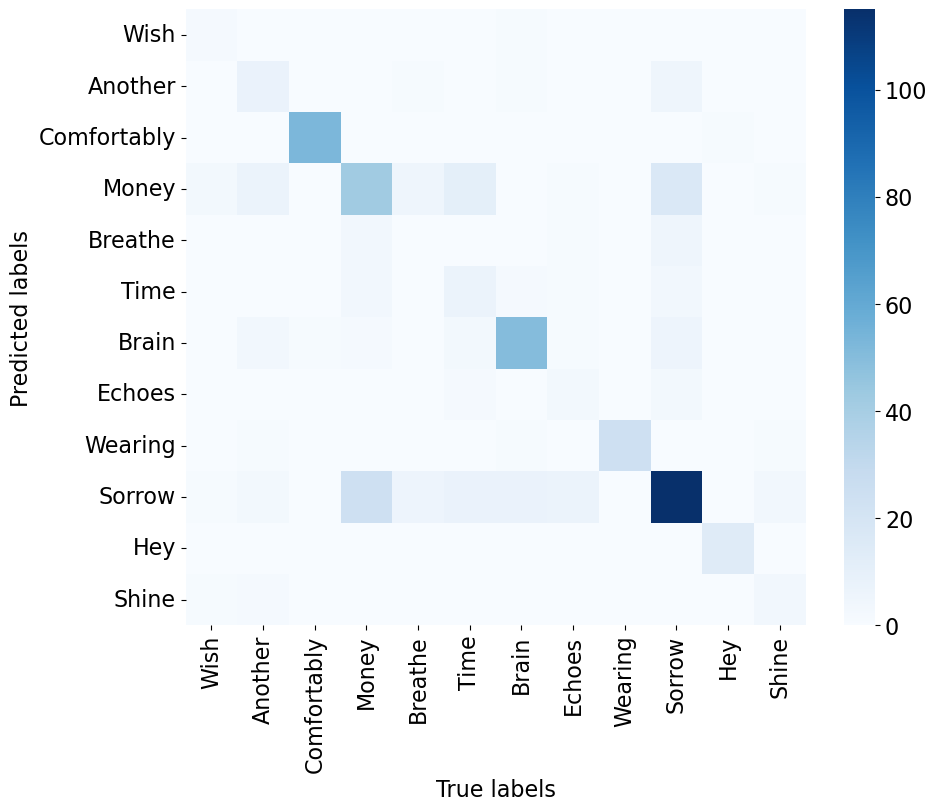

In [176]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### 1D Convolutional Neural Network

In [177]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [178]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 36, 128)           2432      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 18, 128)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 global_average_pooling1d_3   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_17 (Dropout)        (None, 128)               0     

In [179]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
14/14 [==============================] - 1s 29ms/step - loss: 27.9296 - accuracy: 0.0852 - val_loss: 5.7024 - val_accuracy: 0.0410 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - 0s 14ms/step - loss: 10.3306 - accuracy: 0.0950 - val_loss: 6.0454 - val_accuracy: 0.0564 - lr: 0.0010
Epoch 3/200
14/14 [==============================] - 0s 14ms/step - loss: 5.2826 - accuracy: 0.1722 - val_loss: 2.7822 - val_accuracy: 0.2872 - lr: 0.0010
Epoch 4/200
14/14 [==============================] - 0s 13ms/step - loss: 3.7637 - accuracy: 0.2203 - val_loss: 2.4300 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/200
14/14 [==============================] - 0s 13ms/step - loss: 2.9700 - accuracy: 0.2769 - val_loss: 2.3714 - val_accuracy: 0.3385 - lr: 0.0010
Epoch 6/200
14/14 [==============================] - 0s 13ms/step - loss: 2.7025 - accuracy: 0.3015 - val_loss: 2.3653 - val_accuracy: 0.4103 - lr: 0.0010
Epoch 7/200
14/14 [==============================] - 0s 14ms/step - 

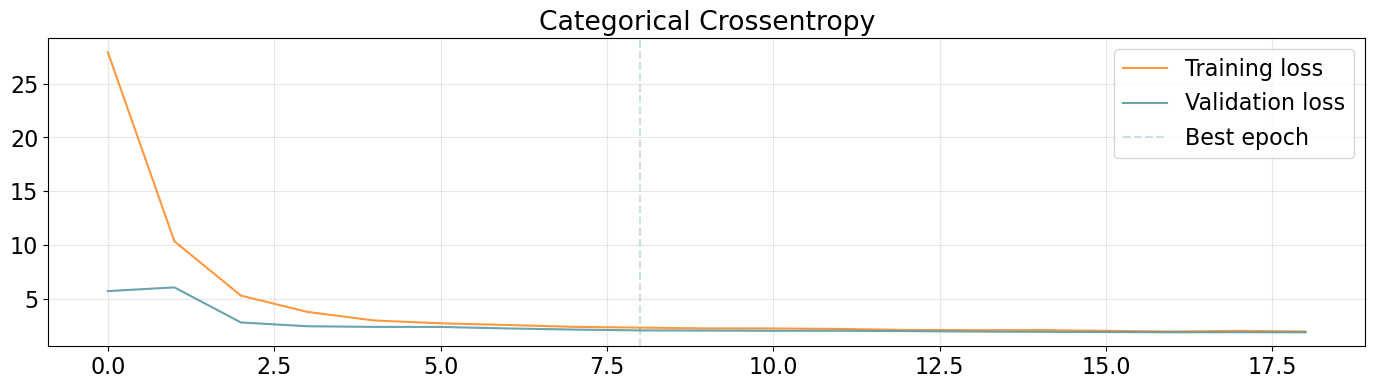

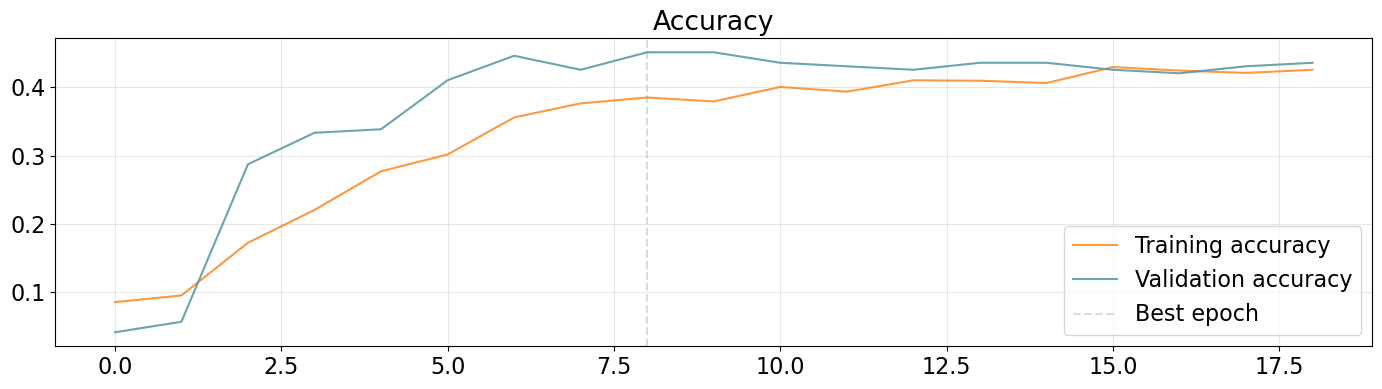

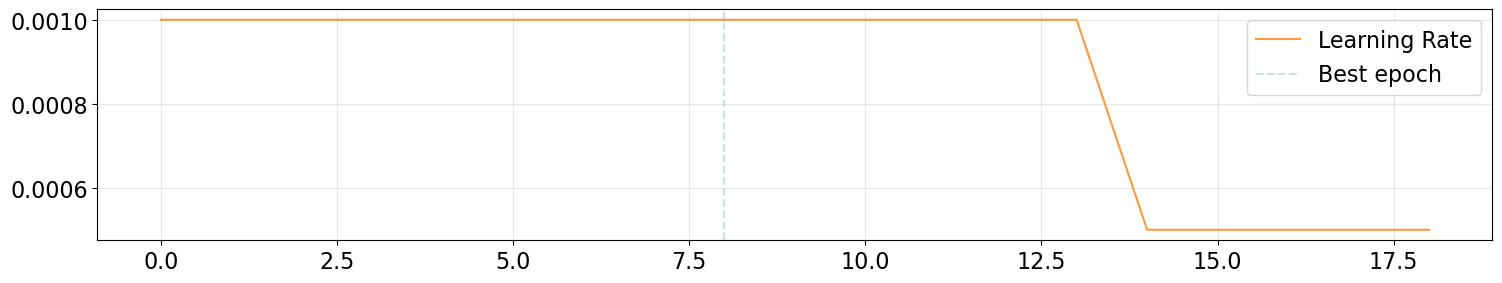

In [180]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Convolution in 1D model evaluation

In [181]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

16/16 [==============================] - 0s 4ms/step


(486, 12)

Accuracy: 0.4321
Precision: 0.2958
Recall: 0.2305
F1: 0.2043


d:\Programs\Anaconda\envs\anndl\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


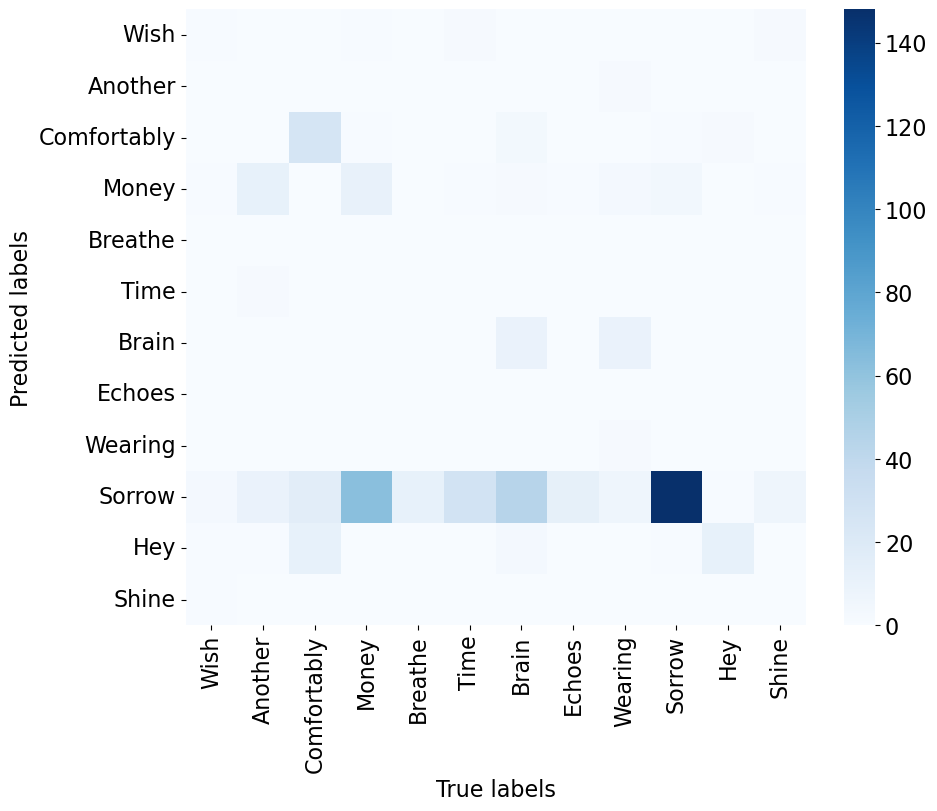

In [182]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()